문제 1 데이터 정규화를 위한 Mean과 Std 값 찾기

1-1 train & validation dataset mean, std
mean: 0.286041
std: 0.353024

1-2 test dataset mean, std
mean: 0.286849
std: 0.352444

문제 2 Fashion MNIST 데이터에 대하여 CNN 학습시키기기

In [2]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys
sys.path.append(BASE_PATH)

from c_trainer import ClassificationTrainer
from a_fashion_mnist_data import get_fashion_mnist_data
from a_fashion_mnist_data import get_fashion_mnist_test_data
from a_arg_parser import get_parser

import torchvision

def get_resnet_model(num_classes=10):
  class ResnetBlock(nn.Module):
    def __init__(self, out_channels, stride=1, downsample=None):
      super().__init__()
      self.conv1 = nn.LazyConv2d(out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn1 = nn.LazyBatchNorm2d()
      self.conv2 = nn.LazyConv2d(out_channels, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn2 = nn.LazyBatchNorm2d()
      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample
      self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
      identity = x
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.dropout(out)
      out = self.conv2(out)
      out = self.bn2(out)
      if self.downsample is not None:
        identity = self.downsample(x)
      out += identity
      out = self.relu(out)
      out = self.dropout(out)
      return out

  class ResNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)
      self.bn1 = nn.LazyBatchNorm2d()
      self.relu = nn.ReLU(inplace=True)
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

      self.layer1 = self._make_layer(32, blocks=1, stride=1)
      self.layer2 = self._make_layer(64, blocks=1, stride=2)
      self.layer3 = self._make_layer(128, blocks=1, stride=2)
      self.layer4 = self._make_layer(256, blocks=1, stride=2)

      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.dropout = nn.Dropout(p=0.3)
      self.fc = nn.LazyLinear(num_classes)

    def _make_layer(self, out_channels, blocks, stride):
      downsample = None
      if stride != 1:
        downsample = nn.Sequential(
          nn.LazyConv2d(out_channels, kernel_size=1, stride=stride, bias=False),
          nn.LazyBatchNorm2d()
        )
      layers = [ResnetBlock(out_channels, stride=stride, downsample=downsample)]
      for _ in range(1, blocks):
        layers.append(ResnetBlock(out_channels))
      return nn.Sequential(*layers)

    def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.fc(x)
      return x

  return ResNet()

/home/kroad/link_dl


In [4]:
parser = get_parser()
args = parser.parse_args([])

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

config = {
  'epochs': args.epochs,
  'batch_size': args.batch_size,
  'validation_intervals': args.validation_intervals,
  'learning_rate': args.learning_rate,
  'early_stop_patience': args.early_stop_patience,
  'early_stop_delta': args.early_stop_delta
}

project_name = "f_mnist_resnet"
name = "resnet_{0}".format(run_time_str)
wandb.init(
  mode="online" if args.wandb else "disabled",
  project=project_name,
  notes="f_mnist experiment with resnet",
  tags=["resnet", "f_mnist"],
  name=name,
  config=config
)
print(args)
print(wandb.config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")

train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
model = get_resnet_model(num_classes=10)
model.to(device)

from torchinfo import summary
summary(
  model=model, input_size=(1, 1, 28, 28),
  col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"]
)

optimizer = optim.AdamW(model.parameters(), lr=wandb.config.learning_rate, weight_decay=1e-3)

classification_trainer = ClassificationTrainer(
  project_name + "_resnet", model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
  run_time_str, wandb, device, CHECKPOINT_FILE_PATH
)
classification_trainer.train_loop()

wandb.finish()

wandb: Currently logged in as: seongjh1105 (seongjh1105-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=256, epochs=500, learning_rate=0.001, validation_intervals=10, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 500, 'batch_size': 256, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05}
Training on device cuda:0.
[Epoch   1] T_loss: 0.77229, T_accuracy: 71.3018 | V_loss: 0.44960, V_accuracy: 83.3000 | Early stopping is stated! | T_time: 00:00:02, T_speed: 0.500
[Epoch  10] T_loss: 0.30222, T_accuracy: 88.8036 | V_loss: 0.26677, V_accuracy: 90.7600 | V_loss decreased (0.44960 --> 0.26677). Saving model... | T_time: 00:00:22, T_speed: 0.455
[Epoch  20] T_loss: 0.25675, T_accuracy: 90.3891 | V_loss: 0.24458, V_accuracy: 91.5600 | V_loss decreased (0.26677 --> 0.24458). Saving model... | T_time: 00:00:44, T_speed: 0.455
[Epoch  30] T_loss: 0.22914, T_accuracy: 91.5436 | V_loss: 0.25025, V_accuracy: 91.1200 | Early stopping counter: 1 out of 10 | T_time: 00:01:06, T_speed: 0.455
[Epoch  40] T_

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Training accuracy (%),▁▆▇▇▇▇▇█████████████
Training loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▁▆▇▇█▇██████████████
Validation loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
Epoch,190
Training accuracy (%),94.8
Training loss,0.13687
Training speed (epochs/sec.),0.45455
Validation accuracy (%),92.52


validation accuracy: 92.52%
learning rate: 1e-3
batch size: 256
early stop patience: 10
weight decay value: 1e-3
dropout rate: 0.3

문제 3 학습 완료된 모델로 테스트 데이터 accuracy 확인하기

In [ ]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms

f_mnist_test_images, test_loader, test_transforms = get_fashion_mnist_test_data()

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

model_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.286849, std=0.352444),
])

correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images = test_transforms(images).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
Test Accuracy: 92.00%


test accuracy: 92.00%

문제 4 샘플 테스트 데이터 분류 예측 결과 확인하기

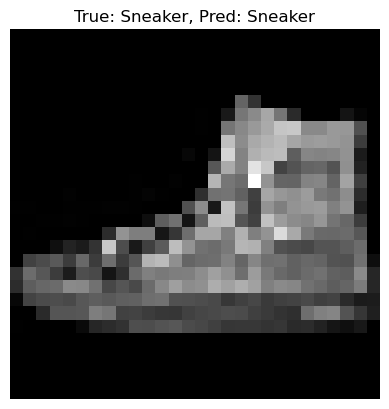

Sample 1:
  True Label: 7 (Sneaker)
  Predicted Label: 7 (Sneaker)
  Match: True



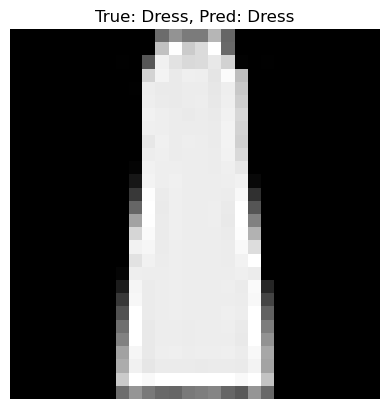

Sample 2:
  True Label: 3 (Dress)
  Predicted Label: 3 (Dress)
  Match: True



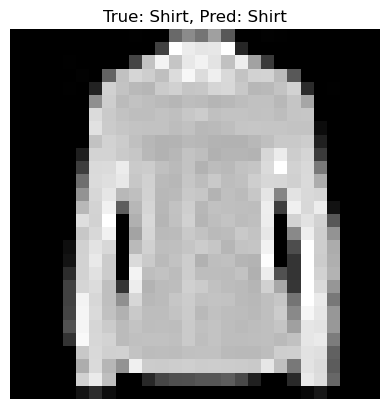

Sample 3:
  True Label: 6 (Shirt)
  Predicted Label: 6 (Shirt)
  Match: True



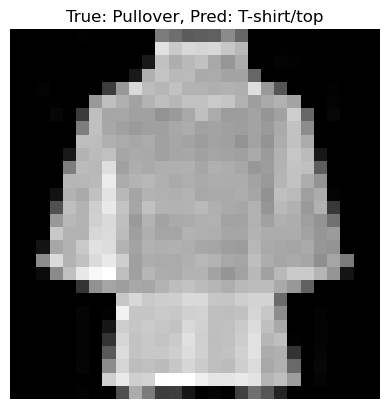

Sample 4:
  True Label: 2 (Pullover)
  Predicted Label: 0 (T-shirt/top)
  Match: False



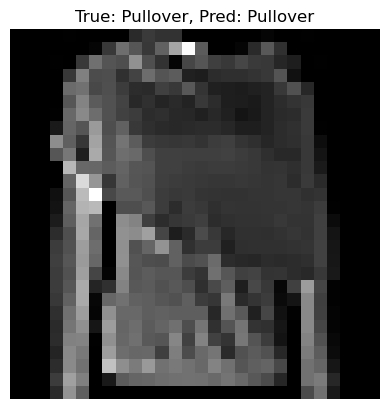

Sample 5:
  True Label: 2 (Pullover)
  Predicted Label: 2 (Pullover)
  Match: True



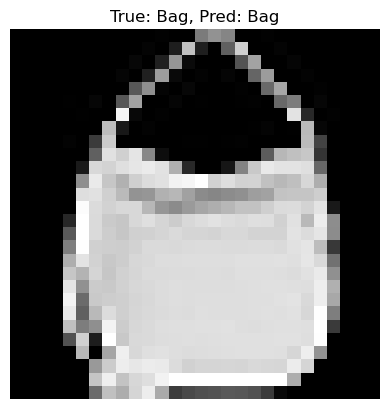

Sample 6:
  True Label: 8 (Bag)
  Predicted Label: 8 (Bag)
  Match: True



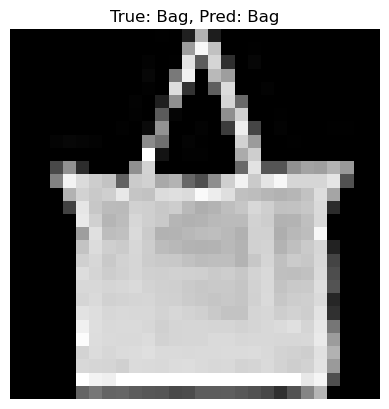

Sample 7:
  True Label: 8 (Bag)
  Predicted Label: 8 (Bag)
  Match: True



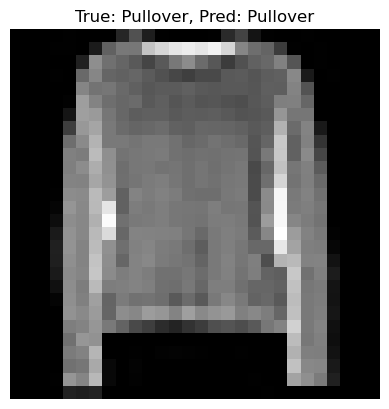

Sample 8:
  True Label: 2 (Pullover)
  Predicted Label: 2 (Pullover)
  Match: True



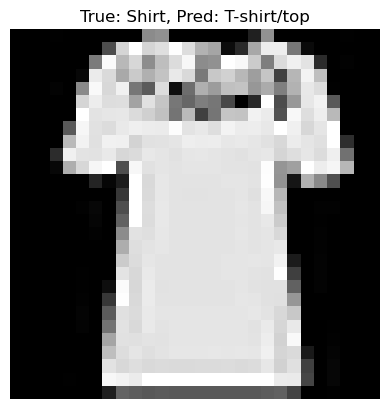

Sample 9:
  True Label: 6 (Shirt)
  Predicted Label: 0 (T-shirt/top)
  Match: False



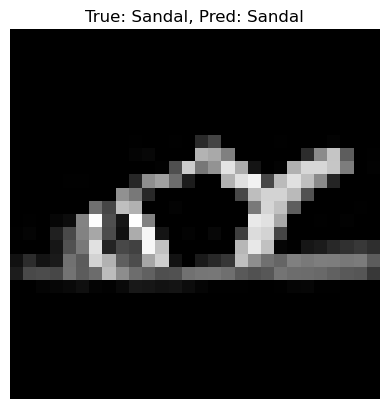

Sample 10:
  True Label: 5 (Sandal)
  Predicted Label: 5 (Sandal)
  Match: True



In [ ]:
num_samples = 10
indices = random.sample(range(len(f_mnist_test_images)), num_samples)

for i, idx in enumerate(indices):
    image, label = f_mnist_test_images[idx]

    input_tensor = model_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()

    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {class_names[label]}, Pred: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()

    print(f"Sample {i+1}:")
    print(f"  True Label: {label} ({class_names[label]})")
    print(f"  Predicted Label: {pred_label} ({class_names[pred_label]})")
    print(f"  Match: {label == pred_label}\n")

sample 4와 sample9의 예측이 실패함

sample 4의 경우
실제 Pullover(스웨터)이지만 T-shirt/top(티셔츠/상의)이라고 예측함
스웨터 또한 상의이므로 비슷한 외관이어서 잘못 예측한 것으로 추정

sample 9의 경우
실제 Shirt(셔츠)이지만 T-shirt/top(티셔츠/상의)이라고 예측함
셔츠 또한 상의이고 티셔츠와 비슷하므로 잘못 예측한 것으로 추정

숙제 후기

이번에 CNN 학습을 잘 시키기 위해 파라미터 튜닝을 하면서 각각의 역할과 기능을 더욱 자세히 이해할 수 있었다.